
**Retinal Red Lesions Segmentation Using Advanced Image Analysis methods and Machine Learning**
> This code is written by:

1.   Husam Nujaim
2.   Tewele Tareke
3.   Anastasiia Rozhyna
4.   Aroz Hada


In [ ]:
import numpy as np
import cv2
import os 
import matplotlib.pyplot as plt
from PIL import Image
from skimage.feature import greycomatrix, greycoprops
from skimage import io
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pandas import ExcelWriter
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import pandas as pd
from skimage.measure import shannon_entropy
import pickle
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from skimage import feature
from skimage.feature import haar_like_feature
from skimage.transform import integral_image
import math 
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_similarity_score
import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import auc

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
#Initializing the paths of the training set 
image_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/OriginalImages/TrainingSet/"
HE_mask_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Groundtruths/TrainingSet/Haemorrhages/"
MA_mask_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Groundtruths/TrainingSet/Microaneurysms/"
RedLesions_candidates_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Candidates/RedLesions/"
RedLesions_Features_path = '/content/drive/MyDrive/DRsegmentation/IP_ML/Final/Training/TrainingSet_RedLesions.xlsx'
RedLesions_IP_Evaluation_path = '/content/drive/MyDrive/DRsegmentation/IP_ML/Final/Training/RedLesions_IP_Evaluation.xlsx'
images = os.listdir(image_path)
HE_masks = os.listdir(HE_mask_path)
MA_masks = os.listdir(MA_mask_path)
images.sort()
HE_masks.sort()
MA_masks.sort()


**Declaring the functions to be used in the segmentation process**

In [ ]:
# Adaptive histogram equalization  
def clahe_equalized(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl1 = clahe.apply(img)
    return  cl1

# Adjust Gamma
def adjust_gamma(image, gamma=1.0):
   table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")
   return cv2.LUT(image, table)

#Automatic Image Thresholding using OTSU method
def OTSU(img_gray):
    max_g = 0
    suitable_th = 0
    th_begin = 0
    th_end = 256
    for threshold in range(th_begin, th_end):
        bin_img = img_gray > threshold
        bin_img_inv = img_gray <= threshold
        fore_pix = np.sum(bin_img)
        back_pix = np.sum(bin_img_inv)
        if 0 == fore_pix:
            break
        if 0 == back_pix:
            continue
 
        w0 = float(fore_pix) / img_gray.size
        u0 = float(np.sum(img_gray * bin_img)) / fore_pix
        w1 = float(back_pix) / img_gray.size
        u1 = float(np.sum(img_gray * bin_img_inv)) / back_pix
        # intra-class variance
        g = w0 * w1 * (u0 - u1) * (u0 - u1)
        if g > max_g:
            max_g = g
            suitable_th = threshold
 
    return suitable_th

#Vessels extraction
def vessel(img):
    dst = 255 - img
    clahe = cv2.createCLAHE(clipLimit=0.18,tileGridSize=(1,1))
    Ien = clahe.apply(dst)  
    kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
    opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
    final = cv2.subtract(Ien,opening)
    test =  OTSU(final)
    ret , binary = cv2.threshold (final ,test, test, cv2.THRESH_BINARY) 
    binary = cv2.medianBlur(binary, 3) 
    return binary


#Evaluate the result of the segmentation 
def evaluation(image, mask):
    
    zeros_list_img, one_list_img, zeros_list_mk, one_list_mk = [], [], [], []
    
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            val_mk = mask[i][j]
            val_img  = image[i][j]
            if val_mk == 0:
                zeros_list_mk.append((i,j))
            else:
                one_list_mk.append((i,j))
            if val_img == 0:
                zeros_list_img.append((i,j))
            else:
                one_list_img.append((i,j))
    TP = len(set(one_list_img).intersection(set(one_list_mk)))
    TN = len(set(zeros_list_img).intersection(set(zeros_list_mk)))
    FP = len(set(one_list_img).intersection(set(zeros_list_mk)))
    FN = len(set(zeros_list_img).intersection(set(one_list_mk)))
    P=0
    R=0
    TPR = 0
    TNR = 0
    if (TP+FP) !=0:
      P = TP/(TP + FP)
    if (TP+FN) !=0: 
      R = TP/(TP + FN)
      TPR=R
    if (TN + FP) !=0:
      TNR = TN/(TN + FP)
    return R, P, TPR, TNR 


# Extract the GLCM features of one region 
def GLCM_feature_extractor(region):
    features = pd.DataFrame()
    for i in range(60):
      if i==0: 
        GLCM = greycomatrix(region, [1], [0]) 
      elif i==1:
        GLCM = greycomatrix(region, [2], [0])  
      elif i==2:
        GLCM = greycomatrix(region, [3], [0]) 
      elif i==3:
        GLCM = greycomatrix(region, [4], [0])
      elif i==4:
        GLCM = greycomatrix(region, [5], [0])
      elif i==5:
        GLCM = greycomatrix(region, [6], [0])
      elif i==6:
        GLCM = greycomatrix(region, [7], [0])
      elif i==7:
        GLCM = greycomatrix(region, [8], [0])
      elif i==8:
        GLCM = greycomatrix(region, [9], [0])
      elif i==9:
        GLCM = greycomatrix(region, [10], [0]) 
      elif i==10:
        GLCM = greycomatrix(region, [11], [0])  
      elif i==11:
        GLCM = greycomatrix(region, [12], [0]) 
      elif i==12:
        GLCM = greycomatrix(region, [13], [0])
      elif i==13:
        GLCM = greycomatrix(region, [14], [0])
      elif i==14:
        GLCM = greycomatrix(region, [15], [0])
      elif i==15:
        GLCM = greycomatrix(region, [16], [0])
      elif i==16:
        GLCM = greycomatrix(region, [17], [0])
      elif i==17:
        GLCM = greycomatrix(region, [18], [0])
      elif i==18:
        GLCM = greycomatrix(region, [19], [0]) 
      elif i==19:
        GLCM = greycomatrix(region, [20], [0])
      elif i==20:
        GLCM = greycomatrix(region, [1], [np.pi/4]) 
      elif i==21:
        GLCM = greycomatrix(region, [2], [np.pi/4])  
      elif i==22:
        GLCM = greycomatrix(region, [3], [np.pi/4]) 
      elif i==23:
        GLCM = greycomatrix(region, [4], [np.pi/4])
      elif i==24:
        GLCM = greycomatrix(region, [5], [np.pi/4])
      elif i==25:
        GLCM = greycomatrix(region, [6], [np.pi/4])
      elif i==26:
        GLCM = greycomatrix(region, [7], [np.pi/4])
      elif i==27:
        GLCM = greycomatrix(region, [8], [np.pi/4])
      elif i==28:
        GLCM = greycomatrix(region, [9], [np.pi/4])
      elif i==29:
        GLCM = greycomatrix(region, [10], [np.pi/4]) 
      elif i==30:
        GLCM = greycomatrix(region, [11], [np.pi/4])  
      elif i==31:
        GLCM = greycomatrix(region, [12], [np.pi/4]) 
      elif i==32:
        GLCM = greycomatrix(region, [13], [np.pi/4])
      elif i==33:
        GLCM = greycomatrix(region, [14], [np.pi/4])
      elif i==34:
        GLCM = greycomatrix(region, [15], [np.pi/4])
      elif i==35:
        GLCM = greycomatrix(region, [16], [np.pi/4])
      elif i==36:
        GLCM = greycomatrix(region, [17], [np.pi/4])
      elif i==37:
        GLCM = greycomatrix(region, [18], [np.pi/4])
      elif i==38:
        GLCM = greycomatrix(region, [19], [np.pi/4]) 
      elif i==39:
        GLCM = greycomatrix(region, [20], [np.pi/4])

      elif i==40:
        GLCM = greycomatrix(region, [1], [np.pi/2]) 
      elif i==41:
        GLCM = greycomatrix(region, [2], [np.pi/2])  
      elif i==42:
        GLCM = greycomatrix(region, [3], [np.pi/2]) 
      elif i==43:
        GLCM = greycomatrix(region, [4], [np.pi/2])
      elif i==44:
        GLCM = greycomatrix(region, [5], [np.pi/2])
      elif i==45:
        GLCM = greycomatrix(region, [6], [np.pi/2])
      elif i==46:
        GLCM = greycomatrix(region, [7], [np.pi/2])
      elif i==47:
        GLCM = greycomatrix(region, [8], [np.pi/2])
      elif i==48:
        GLCM = greycomatrix(region, [9], [np.pi/2])
      elif i==49:
        GLCM = greycomatrix(region, [10], [np.pi/2])       
      elif i==50:
        GLCM = greycomatrix(region, [11], [np.pi/2])  
      elif i==51:
        GLCM = greycomatrix(region, [12], [np.pi/2]) 
      elif i==52:
        GLCM = greycomatrix(region, [13], [np.pi/2])
      elif i==53:
        GLCM = greycomatrix(region, [14], [np.pi/2])
      elif i==54:
        GLCM = greycomatrix(region, [15], [np.pi/2])
      elif i==55:
        GLCM = greycomatrix(region, [16], [np.pi/2])
      elif i==56:
        GLCM = greycomatrix(region, [17], [np.pi/2])
      elif i==57:
        GLCM = greycomatrix(region, [18], [np.pi/2])
      elif i==58:
        GLCM = greycomatrix(region, [19], [np.pi/2]) 
      elif i==59:
        GLCM = greycomatrix(region, [20], [np.pi/2]) 

      GLCM_Energy = greycoprops(GLCM, 'energy')[0]
      features['Energy'+str(i+1)] = GLCM_Energy
      GLCM_corr = greycoprops(GLCM, 'correlation')[0]
      features['Correlation'+str(i+1)] = GLCM_corr       
      GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
      features['Dissimilarity'+str(i+1)] = GLCM_diss       
      GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
      features['Homogeneity'+str(i+1)] = GLCM_hom       
      GLCM_contr = greycoprops(GLCM, 'contrast')[0]
      features['Contrast'+str(i+1)] = GLCM_contr        
    #Add more filters as needed
    entropy = shannon_entropy(region)
    features['Entropy'] = entropy
    return features





#Candidates extraction after the image processing is done 
def candidates_selection2(original_img,rimg,im_mask_1,im_mask_2,typeOfLesion=1):
    contours, hierarchy = cv2.findContours(rimg,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    idx =0 
    t_features = pd.DataFrame()
    t_labels = [] 
    for cnt in contours:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        roi=rimg[y:y+h,x:x+w]
        #cv2.rectangle(originalImage,(x,y),(x+w,y+h),(0,255,255),5)
        regions_img=rimg[y:y+h, x:x+w]
        regions_1=im_mask_1[y:y+h, x:x+w]
        regions_2=im_mask_2[y:y+h, x:x+w]
        S_1,p,tpr,tnr = evaluation(regions_img, regions_1)
        S_2,p,tpr,tnr = evaluation(regions_img, regions_2)
        t_features=t_features.append(feature_extractor(cv2.cvtColor(original_img[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY)))
        if typeOfLesion == 1: # Exudates
            if (S_1 > 0.1) and (S_1 >= S_2):
              t_labels.append(1)  #Hard Exudate
            elif (S_2>0.1) and (S_2 >= S_1):
              t_labels.append(2)   #Soft Exudate
            else:
              t_labels.append(0)   #Background
        else:  #Red Lesions
            if (S_1 > 0.1) and (S_1 >= S_2):
              t_labels.append(3)  #Microaneurysms
            elif (S_2>0.1) and (S_2 >= S_1):
              t_labels.append(4)   #Hemorrhages
            else:
              t_labels.append(0)   #Background

    return t_features, t_labels




#Utility function to easily plot images
def plot(myimg,mtype="gray"):
  if mtype=="gray":
    plt.imshow(myimg,cmap= mtype)
  else:
    plt.imshow(cv2.cvtColor(myimg, cv2.COLOR_BGR2RGB))
  plt.show()

#Train different ML classifiers 
def train(classifier,X_train,y_train):
    if classifier=='LGBM':
        #Class names for LGBM start at 0 so reassigning labels from 1,2,3,4 to 0,1,2,3
        d_train = lgb.Dataset(X_train, label=y_train)

        # https://lightgbm.readthedocs.io/en/latest/Parameters.html
        lgbm_params = {'learning_rate':0.05, 'boosting_type':'dart',    
                       'objective':'multiclass',
                       'metric': 'multi_logloss',
                       'num_leaves':100,
                       'max_depth':10,
                       'num_class':3
                       ,'class_weight':'balanced'}  #no.of unique values in the target class not inclusive of the end value
        my_model = lgb.train(lgbm_params, d_train, 100) #50 iterations. Increase iterations for small learning rates
    elif  classifier=='RF':
        my_model = RandomForestClassifier(n_estimators = 100, random_state = 42, class_weight="balanced")
        my_model.fit(X_train, y_train) 
    elif classifier=='SVM':
        #my_model = svm.SVC(decision_function_shape='ovo')  #For multiclass classification
        #my_model.fit(X_train, y_train)
        my_model = svm.SVC(kernel='rbf', gamma=0.5, C=0.1, class_weight="balanced").fit(X_train, y_train)
        #my_model = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)
    return my_model

#Predict the classes of the test set 
def predict(mymodel,X_test,y_test):
  test_pred = mymodel.predict(X_test)
  f1=metrics.f1_score(y_test, test_pred,average='weighted')
  df = pd.DataFrame()
  y_test = np.array(y_test)
  y_test = y_test.flatten()
  df['y_test'] = y_test
  df['test_pred'] = test_pred
  writer = ExcelWriter('/content/drive/MyDrive/DRsegmentation/IP_ML/Training/acc_exudates_test.xlsx')
  df.to_excel(writer,'Sheet5')
  writer.save()
  return f1,test_pred

#Print confusion matrix
def CM_plot(y_test, test_pred):
    cm = confusion_matrix(y_test, test_pred)
    fig, ax = plt.subplots(figsize=(6,6))
    sns.set(font_scale=1.6)
    sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


def extract_RedLesions(img):
    gray  = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    T, B_Fov = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    b,g,r = cv2.split(img)
    Ienhance = clahe_equalized(g)
    Ienhance =adjust_gamma((255-Ienhance),gamma=2)
    Ienhance = 255 -Ienhance
    #plot(Ienhance)
    Imedfilter = cv2.medianBlur(Ienhance,211)
    Isub = cv2.subtract(Imedfilter,Ienhance)
    Isub_filter = cv2.blur(Isub,(5,5))
    Isub_filter = cv2.bitwise_and(Isub,B_Fov)
    bestTh = OTSU(Isub_filter)
    T,Idark_tep = cv2.threshold(Isub_filter, bestTh, 255, cv2.THRESH_BINARY)
    sOP = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
    Bdark = cv2.morphologyEx(Idark_tep,cv2.MORPH_OPEN,sOP)

    Imed = cv2.medianBlur(Ienhance,241)
    Isub1 = cv2.subtract(Imed,Ienhance)
    Isub_filter1 = cv2.blur(Isub1,(5,5))
    bestTh1 =  OTSU(Isub_filter1)
    T,Idark_tep1 = cv2.threshold(Isub_filter1, bestTh1, 255, cv2.THRESH_BINARY)
    Bdark1 = cv2.morphologyEx(Idark_tep1,cv2.MORPH_OPEN,sOP)

    Bduel = cv2.bitwise_or(Bdark,Bdark1)
    Bduel= cv2.bitwise_and(Bduel,B_Fov)
    
    Ismooth = cv2.GaussianBlur(Ienhance,(7,7),0)
    Ivessel = vessel(Ismooth)
    kernel = np.ones((5, 5), np.uint8)
    Ivessel = cv2.dilate(Ivessel, kernel)
    Bduel = cv2.erode(Bduel,kernel)
    same = cv2.bitwise_and(Ivessel,Bduel)

    result = cv2.subtract(Bduel,same)
    sOP6 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)) #6,6
    result = cv2.morphologyEx(result,cv2.MORPH_OPEN,sOP6)
    result = cv2.erode(result,kernel)

    sOP10 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)) #10,10
    result1 = cv2.morphologyEx(result,cv2.MORPH_OPEN,sOP10)

    result = cv2.bitwise_or(result,result1)
    result =  cv2.dilate(result, kernel)



    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    vessels = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel, iterations=1)
    cnts = cv2.findContours(vessels, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 20000:
            cv2.drawContours(vessels, [c], -1, (0,0,0), -1)

    res = cv2.subtract(result,vessels)

    return res



#Local Binary Patterns 
def LBP_feature_extractor(region, numPoints,radius, eps=1e-7):
    df= pd.DataFrame() ;
    lbp = feature.local_binary_pattern(region, numPoints,radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, numPoints + 3),
                             range=(0, numPoints + 2))
    for i in range(hist.shape[0]):
      df['LBP_'+str(i+1)] =[hist[i]]
    return df


#Geometric Shape Features  
def Shape_feature_extractor(region, w,h):
    shp_features= pd.DataFrame()
    M = cv2.moments(region)
    for i in range(4):
      for j in range(4):
        if i==0 and j==0:
          shp_features['m00'] = [M['m00']]
        elif i+j <=3:
          shp_features['m'+str(i)+''+str(j)] = [M['m'+str(i)+''+str(j)]]

    shp_features['nu20'] = [M['nu20']]
    shp_features['nu02'] = [M['nu02']]
    shp_features['nu30'] = [M['nu30']]
    shp_features['nu21'] = [M['nu21']]
    shp_features['nu12'] = [M['nu12']]
    shp_features['nu03'] = [M['nu03']]
    #Hu Moments 
    huMoments = cv2.HuMoments(M)
    for i in range(7):
      shp_features['hu'+str(i+1)] = huMoments[i]

    #Shape features 
    area = cv2.contourArea(region)
    perimeter = cv2.arcLength(region,True)
    eccentricity = w/h #math.sqrt((1- (pow(w, 2)/pow(h, 2)))) #degree of elongation
    shp_features['Area'] = [area]
    shp_features['Perimeter'] =[perimeter]
    shp_features['Eccentricity'] =[eccentricity]
    return shp_features

#Candidates extraction after the image processing is done 
def candidates_selection(original_img,rimg,im_mask_1,im_mask_2):
    contours, hierarchy = cv2.findContours(rimg,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    idx =0 
    glcm_features = pd.DataFrame()
    lbp_features = pd.DataFrame()
    shape_features= pd.DataFrame()
    t_labels = [] 
    for cnt in contours:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        roi=rimg[y:y+h,x:x+w]
        #cv2.rectangle(originalImage,(x,y),(x+w,y+h),(0,255,255),5)
        regions_img=rimg[y:y+h, x:x+w]
        regions_1=im_mask_1[y:y+h, x:x+w]
        regions_2=im_mask_2[y:y+h, x:x+w]
        S_1,p,tpr,tnr = evaluation(regions_img, regions_1)
        S_2,p,tpr,tnr = evaluation(regions_img, regions_2)
        b,g,r = cv2.split(original_img)
        #Extract Shape Features 
        shape_features=shape_features.append(Shape_feature_extractor(cnt,w,h))
        #Extract GLCM Features
        glcm_features=glcm_features.append(GLCM_feature_extractor(g[y:y+h, x:x+w]))
        #Extract Local Binary Patterns 
        lbp_features=lbp_features.append(LBP_feature_extractor(g[y:y+h, x:x+w],9, 3))
        #Merge all the features in one data frame 
        t_features = pd.concat([glcm_features, lbp_features, shape_features], axis=1)
        if (S_1 > 0.05) and (S_1 >= S_2):
          t_labels.append(1)  #Microaneurysms
        elif (S_2>0.05) and (S_2 >= S_1):
          t_labels.append(2)   #Hemorrhages
        else:
          t_labels.append(0)   #Background

    return t_features, t_labels


**Candidates and features extraction from the whole training images**


> This involves: 


1.   Reading the original images with thier corresponding masks
2.   Extract the candidate regions of the MA and HE 
3.   Extract the GLCM features of each candidate region and save it as a training set for the ML pipline




In [ ]:
train_features = pd.DataFrame()  #the training features 
train_labels = [] #the corresponding lables of the features 

#loop through the whole original images of the training set 
for img_number in range(len(images)):
    #Prepare the images path
    image = image_path + images[img_number]
    he_mask = HE_mask_path + HE_masks[img_number]
    ma_mask = MA_mask_path + MA_masks[img_number]
    red_p = RedLesions_candidates_path + Red_candidates[img_number]

    #Read the images 
    original_img = cv2.imread(image)
    mask_he = cv2.imread(he_mask)
    mask_ma = cv2.imread(ma_mask)
    
    #Plot the images and binarize the masks 
    print(img_number,": OriginalImage")
    plot(original_img,"RBG")
    im_mask_ma = cv2.cvtColor(mask_ma, cv2.COLOR_BGR2GRAY)
    th, im_mask_ma = cv2.threshold(im_mask_ma, 10, 255, cv2.THRESH_BINARY)
    im_mask_he = cv2.cvtColor(mask_he, cv2.COLOR_BGR2GRAY)
    th, im_mask_he = cv2.threshold(im_mask_he, 10, 255, cv2.THRESH_BINARY)

    #Segment the exudates and the red lesions
    Red_candidate_regions = cv2.imread(red_p)    
    Red_candidate_regions = cv2.cvtColor(Red_candidate_regions, cv2.COLOR_BGR2GRAY)
    th, Red_candidate_regions = cv2.threshold(Red_candidate_regions, 10, 255, cv2.THRESH_BINARY)

    print(img_number,": lesions_segmented")
    plot(Red_candidate_regions)

    # Get the candidates & their GLCM features with lables 
    Red_candidate_regions = Red_candidate_regions.astype(np.uint8)
    red_features, red_labels = candidates_selection(original_img,Red_candidate_regions,im_mask_ma,im_mask_he)
    train_features=train_features.append(red_features)
    train_labels.append(red_labels)
    #Evaluate the result of the image processing (candidate regions). We bank on the sensitivity metric in this stage. 
    exR, exP, exTPR, exTNR  = evaluation(lesions_segmented,im_mask_ex)
    seR, seP, seTPR, seTNR  = evaluation(lesions_segmented,im_mask_se)
    R_evaluation.loc[img_number] = [str(img_number+1)] + [exR] +[seR]



**Saving the extracted features into an Excel file to be used as a training set in the ML pipline**

In [ ]:
# Save Training set TO EXCEL
train_data = pd.DataFrame(train_features)
temp=[]
for i in range(len(train_labels)):
  for j in range(len(train_labels[i])):
    temp.append(train_labels[i][j])
train_data['Label'] = np.asarray(temp)
writer = ExcelWriter(RedLesions_Features_path)
train_data.to_excel(writer,'Sheet1')
writer.save()

# Save the Evaluation (Sensitivity) of the Image Processing pipline of each image in the training set TO EXCEL
writer = ExcelWriter(RedLesions_IP_Evaluation_path)
R_evaluation.to_excel(writer,'Sheet1')
writer.save()

**Machine Learning Pipline**



> **Reading the dataset from the Excel file that we saved earlier**



> **Under and over sampling the training set to tackle class imbalance**


> **Split the data into training set and test(validation) set**


> **Scaling the features using StandardScaler**


> **Training the ML Classifiers**


> **Evaluating the F1 Score of the classifiers**

In [ ]:
#Reading the RedLesions dataset from Excel file 
RedLesions_Features_path = '/content/drive/MyDrive/DRsegmentation/IP_ML/Final/Training/TrainingSet_RedLesions.xlsx'
train_features = pd.read_excel(RedLesions_Features_path)
# Undersampling the background samples 
train_featuresSaved = train_features
s0 = train_features.Label[train_features.Label.eq(0)].sample(15000).index # Undersampling the background
s1 = train_features.Label[train_features.Label.eq(1)].sample(1068).index # 1068 is the full number of samples  of the MA samples in the dataset
s2 = train_features.Label[train_features.Label.eq(2)].sample(1965).index # 1965 is the full number of samples  of the HE samples in the dataset
train_features = train_features.loc[s0.union(s1).union(s2)]
# Save the new dataset 
writer = ExcelWriter(RedLesions_FeaturesSmall_path)
train_features.to_excel(writer,'Sheet1')
writer.save()
#Reading the undersampled dataset
train_features = pd.read_excel(RedLesions_FeaturesSmall_path)
#removing the index column and the label column 
label=train_features['Label']
train_features=train_features.drop(columns="Label")
train_features = train_features.iloc[: , 1:]
train_x = train_features
train_y = pd.DataFrame()
train_y['Label'] = label


In [ ]:
# Split the data into training set and test(validation) set 
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y,
                                                    stratify=train_y, 
                                                    test_size=0.25)


oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)

#Scaling the features using StandardScaler
x = X_over #returns a numpy array
y_train=y_over


#Scaling the features using StandardScaler                                                           
#x = X_train.values #returns a numpy array
stdScaler = preprocessing.StandardScaler()
# Fit on training set only.
stdScaler.fit(x)

# Apply transform to both the training set and the test set.
X_train = stdScaler.transform(x)
X_test = stdScaler.transform(X_test)

#Save the StdScalar to be used in future inference purposes 
joblib.dump(stdScaler, RedLesions_scaler_filename) 

#Training the Classifier
classifier = "RF" # It can be "RF" "LGBM" or "KNN"
mymodel=train(classifier,X_train,y_train)

#Evaluating the F1 Score of the model on the validation set
f1_score,test_pred = predict(mymodel,X_test,y_test)
print ( "F1 Score = ", f1_score)
target_names = ['B', 'MA', 'HE']
print(classification_report(y_test, test_pred, target_names=target_names))
#Plot the confusion matrix of the predictions
CM_plot(y_test, test_pred)

#Save the ML model to be used in the future 
pickle.dump(mymodel, open(RedLesions_ML_model_filename, 'wb'))

**Testing Phase**

> **Initializing the paths of the test set images**


In [ ]:
image_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/OriginalImages/TestingSet/"


#Red Lesions 
MA_mask_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Groundtruths/TestingSet/Microaneurysms/"
HE_mask_path = "/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Groundtruths/TestingSet/Haemorrhages/"
RedLesions_AIA_Evaluation_path = '/content/drive/MyDrive/DRsegmentation/IP_ML/Final/Testing/RedLesions_AIA_test_Evaluation2.xlsx'
RedLesions_Test_candidates_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Candidates/TestSet/RedLesions/"

MA_Segmentation_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/AIA_ML_Segmentation/Segmentation/MA/2/"
HE_Segmentation_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/AIA_ML_Segmentation/Segmentation/HE/2/"

MA_ConfidenceImage_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/AIA_ML_Segmentation/ConfidenceImage/RedLesions/MA/2/"
HE_ConfidenceImage_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/AIA_ML_Segmentation/ConfidenceImage/RedLesions/HE/2/"
RedLesions_BG_ConfidenceImage_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/AIA_ML_Segmentation/ConfidenceImage/RedLesions/BG/2/"
RedLesions_scaler_filename = "/content/drive/MyDrive/DRsegmentation/IP_ML/Final/Training/RL_scaler2.save"
RedLesions_ML_model_filename = '/content/drive/MyDrive/DRsegmentation/IP_ML/Final/Training/RL_model2.save'
RedLesions_Test_candidates_path ="/content/drive/MyDrive/DRsegmentation/HEDNet_cGAN/data/Candidates/TestSet/RedLesions/"

MA_ConfidenceScore_path = '/content/drive/MyDrive/DRsegmentation/IP_ML/Final/Testing/MA_ConfidenceScore2.xlsx'
HE_ConfidenceScore_path = '/content/drive/MyDrive/DRsegmentation/IP_ML/Final/Testing/HE_ConfidenceScore2.xlsx'


images = os.listdir(image_path)
MA_masks = os.listdir(MA_mask_path)
HE_masks = os.listdir(HE_mask_path)
RedLesions_Test_Candidates = os.listdir(RedLesions_Test_candidates_path)

images.sort()
MA_masks.sort()
HE_masks.sort()
RedLesions_Test_Candidates.sort()

> **Candidate Regions Extraction from the test images**


In [ ]:
R_evaluation = pd.DataFrame(columns=['img_number', 'MA','HE'])  #the sensitivity evaluation of the exudates in each image in the test dataset
#Loading the ML model to be used to refine the segmentation 
mymodel = pickle.load(open(ML_model_filename, 'rb'))

#loop through the whole original images of the training set 
for img_number in range(len(images)):
    # Read Image and Mask
    image = image_path + images[img_number]
    ma_mask = MA_mask_path + MA_masks[img_number]
    he_mask = HE_mask_path + HE_masks[img_number]
    img = cv2.imread(image)
    mask_ma = cv2.imread(ma_mask)
    mask_he = cv2.imread(he_mask)
    print(img_number,": OriginalImage")
    plot(img,"BrBG")
    #Load and plot the mask
    im_mask_he = cv2.cvtColor(mask_he, cv2.COLOR_BGR2GRAY)
    th, im_mask_he = cv2.threshold(im_mask_he, 10, 255, cv2.THRESH_BINARY)
    print(img_number,": mask")
    plot(im_mask_he)
    im_mask_ma = cv2.cvtColor(mask_ma, cv2.COLOR_BGR2GRAY)
    th, im_mask_ma = cv2.threshold(im_mask_ma, 10, 255, cv2.THRESH_BINARY)
    print(img_number,": mask")
    plot(im_mask_ma)

    # segment the exudates
    lesions_segmented = extract_RedLesions(img)
    print(img_number,": lesions_segmented")
    plot(lesions_segmented)
    cv2.imwrite(RedLesions_Test_candidates_path + images[img_number], lesions_segmented)
    
    #Evaluate the result of the image processing (candidate regions). We bank on the sensitivity metric in this stage. 
    maR, maP, maTPR, maTNR  = evaluation(lesions_segmented,im_mask_ma)
    heR, heP, heTPR, heTNR  = evaluation(lesions_segmented,im_mask_he)
    R_evaluation.loc[img_number] = [str(img_number+1)] + [maR] +[heR]
    
# Save the evaluation TO EXCEL
writer = ExcelWriter(RedLesions_AIA_Evaluation_path)
R_evaluation.to_excel(writer,'Sheet1')
writer.save()

**Segmentation of TEST SET**



> **Declaring the functions to be used**



In [ ]:
#Candidates extraction after the image processing is done and using the ML model to refine the segmentation in the inference stage 
def candidates_extraction_for_inference(img_number,imgorginal, mask1, mask2, rimg,mymodel,scalar):
    contours, hierarchy = cv2.findContours(rimg,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
    idx =0 
    region_features = [] 
    preds0=[]
    preds1=[]
    segmented_img1 = np.zeros((imgorginal.shape[0],imgorginal.shape[1]))
    segmented_img2 = np.zeros((imgorginal.shape[0],imgorginal.shape[1]))
    segmented_pred0 = np.zeros((imgorginal.shape[0],imgorginal.shape[1]))
    segmented_pred1 = np.zeros((imgorginal.shape[0],imgorginal.shape[1]))
    segmented_pred2 = np.zeros((imgorginal.shape[0],imgorginal.shape[1]))
    confidenceTable1 = pd.DataFrame()
    confidenceTable2 = pd.DataFrame()
    for cnt in contours:
        idx += 1
        x,y,w,h = cv2.boundingRect(cnt)
        b,g,r = cv2.split(imgorginal)
        shape_features = pd.DataFrame()
        glcm_features = pd.DataFrame()
        lbp_features = pd.DataFrame()
        t_features = pd.DataFrame()
        confidence_table1 = pd.DataFrame()
        confidence_table2 = pd.DataFrame()

        #Extract Shape Features 
        shape_features=shape_features.append(Shape_feature_extractor(cnt,w,h))
        #Extract GLCM Features
        glcm_features=glcm_features.append(GLCM_feature_extractor(g[y:y+h, x:x+w]))
        #Extract Local Binary Patterns 
        lbp_features=lbp_features.append(LBP_feature_extractor(g[y:y+h, x:x+w],9, 3))
        #Merge all the features in one data frame 
        t_features = pd.concat([glcm_features, lbp_features, shape_features], axis=1)
        #Standard Scalar Transformation
        f= t_features.values
        features=scaler.transform(f)
        #features=pca.transform(features)
        #pred= mymodel.predict(features)
        preds=mymodel.predict_proba(features)
        pred= mymodel.predict(features)
        segmented_pred0[y:y+h, x:x+w] = rimg[y:y+h,x:x+w] * preds[:,0]
        segmented_pred1[y:y+h, x:x+w] = rimg[y:y+h,x:x+w] * preds[:,1]
        segmented_pred2[y:y+h, x:x+w] = rimg[y:y+h,x:x+w] * preds[:,2]
        if pred[0]==1:
          segmented_img1[y:y+h, x:x+w] = rimg[y:y+h,x:x+w]
          confidence_table1.at['0', 'img_number'] = img_number
          confidence_table1['Confidence Score'] = preds[:,1]
          R,P,TPR,TNR = evaluation(mask1[y:y+h, x:x+w], rimg[y:y+h,x:x+w])
          if R >=0.2: 
            confidence_table1['Label'] = 'TP'
          else:
            confidence_table1['Label'] = 'FP'
          confidenceTable1 = confidenceTable1.append(confidence_table1)

        elif pred[0]==2:
          segmented_img2[y:y+h, x:x+w] = rimg[y:y+h,x:x+w]
          confidence_table2.at['0', 'img_number'] = img_number
          confidence_table2['Confidence Score'] = preds[:,2]
          R,P,TPR,TNR = evaluation(mask2[y:y+h, x:x+w], rimg[y:y+h,x:x+w])
          if R >=0.2: 
            confidence_table2['Label'] = 'TP'
          else:
            confidence_table2['Label'] = 'FP'
          confidenceTable2 = confidenceTable2.append(confidence_table2)

    return  segmented_img1,confidenceTable1, segmented_img2, confidenceTable2, segmented_pred0, segmented_pred1, segmented_pred2

def segmentByML(img_number,original_img,mask1, mask2, candidateImage, mymodel,scaler ):
     
  segmented_img1, confidence_table1, segmented_img2, confidence_table2, segmented_pred0, segmented_pred1, segmented_pred2=candidates_extraction_for_inference(img_number, original_img, mask1, mask2,candidateImage,mymodel,scaler)
  return segmented_img1, confidence_table1, segmented_img2, confidence_table2, segmented_pred0,segmented_pred1, segmented_pred2




**Segmentation the whole test set images**

In [ ]:
#Red Lesions  
scaler = joblib.load(RedLesions_scaler_filename) 
mymodel =   pickle.load(open(RedLesions_ML_model_filename, 'rb')) 


ma_confidenceTable= pd.DataFrame()
he_confidenceTable= pd.DataFrame()

for img_number in range(len(RedLesions_Test_Candidates)):
    seg_img_path= RedLesions_Test_candidates_path + RedLesions_Test_Candidates[img_number]
    original_path = image_path+images[img_number]
    original_img = cv2.imread(original_path)
    plot(original_img,"RGB")
    ma_mask = MA_mask_path + MA_masks[img_number]
    he_mask = HE_mask_path + HE_masks[img_number]
    mask_ma = cv2.imread(ma_mask)
    mask_he = cv2.imread(he_mask)
    #Load and plot the mask
    im_mask_he = cv2.cvtColor(mask_he, cv2.COLOR_BGR2GRAY)
    th, im_mask_he = cv2.threshold(im_mask_he, 10, 255, cv2.THRESH_BINARY)
    print(img_number,": mask")
    plot(im_mask_he)
    im_mask_ma = cv2.cvtColor(mask_ma, cv2.COLOR_BGR2GRAY)
    th, im_mask_ma = cv2.threshold(im_mask_ma, 10, 255, cv2.THRESH_BINARY)
    print(img_number,": mask")
    plot(im_mask_ma)

    candidateImage = cv2.imread(seg_img_path)
    candidateImage = cv2.cvtColor(candidateImage, cv2.COLOR_BGR2GRAY)
    th, candidateImage = cv2.threshold(candidateImage, 10, 255, cv2.THRESH_BINARY)
    plot(candidateImage)
    ma_segmented_img, ma_confidence_table, he_segmented_img, he_confidence_table, segmented_pred0, segmented_pred1, segmented_pred2 = segmentByML((img_number+1), original_img,im_mask_ma,im_mask_he,candidateImage,mymodel,scaler)
    ma_confidenceTable = ma_confidenceTable.append(ma_confidence_table)
    he_confidenceTable = he_confidenceTable.append(he_confidence_table)

    
    cv2.imwrite(MA_Segmentation_path + str(img_number)+'.jpg', ma_segmented_img)
    cv2.imwrite(HE_Segmentation_path + str(img_number)+'.jpg', he_segmented_img)

    cv2.imwrite(RedLesions_BG_ConfidenceImage_path + str(img_number)+'.jpg', segmented_pred0)
    cv2.imwrite(MA_ConfidenceImage_path + str(img_number)+'.jpg', segmented_pred1)
    cv2.imwrite(HE_ConfidenceImage_path + str(img_number)+'.jpg', segmented_pred2)
    
    plot(ma_segmented_img)
    plot(he_segmented_img)
    plot(segmented_pred0)
    plot(segmented_pred1)
    plot(segmented_pred2)

#Saving the MA_ConfidenceScore
writer = ExcelWriter(MA_ConfidenceScore_path)
ma_confidenceTable.to_excel(writer,'Sheet1')
writer.save()

#Saving the HE_ConfidenceScore
writer = ExcelWriter(HE_ConfidenceScore_path)
he_confidenceTable.to_excel(writer,'Sheet1')
writer.save()


> **Evaluation of the segmentation**


In [ ]:
#Reading the MA_ConfidenceScore and HE_ConfidenceScore
ma_confidenceTable = pd.read_excel(MA_ConfidenceScore_path)
he_confidenceTable = pd.read_excel(HE_ConfidenceScore_path)
#Sorting them based on the Confidence Score
ma_confidenceTable.sort_values('Confidence Score', inplace=True, ascending=False)
he_confidenceTable.sort_values('Confidence Score', inplace=True, ascending=False)

**Counting the number of ground truth objects so as to calculate the recall**

In [ ]:
#Counting the number of ground truth objects so as to calculate the recall 
def countGTobjects(mask):
    contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:] 
    return len(contours)

MA_GT_Objects = 0 


for img_number in range(len(MA_masks)):
    # Read Image and Mask
    ma_mask = MA_mask_path + MA_masks[img_number]
    mask_ma = cv2.imread(ma_mask)
    im_mask_ma = cv2.cvtColor(mask_ma, cv2.COLOR_BGR2GRAY)
    th, im_mask_ma = cv2.threshold(im_mask_ma, 10, 255, cv2.THRESH_BINARY)
    c=countGTobjects(im_mask_ma)
    MA_GT_Objects=MA_GT_Objects + c
    print('Objects: = '+ str(c))
print('Total Objects: = '+ str(MA_GT_Objects))


In [ ]:
HE_GT_Objects = 0 
for img_number in range(len(HE_masks)):
    # Read Image and Mask
    he_mask = HE_mask_path + HE_masks[img_number]
    mask_he = cv2.imread(he_mask)
    im_mask_he = cv2.cvtColor(mask_he, cv2.COLOR_BGR2GRAY)
    th, im_mask_he = cv2.threshold(im_mask_he, 10, 255, cv2.THRESH_BINARY)
    #print(img_number,": mask")
    #plot(im_mask_he)
    c=countGTobjects(im_mask_he)
    HE_GT_Objects=HE_GT_Objects + c
    print('Objects: = '+ str(c))
print('Total Objects: = '+ str(HE_GT_Objects))

**Calculating the Precision and Recall based on the accumlated TP and FP**

In [ ]:
confidenceTableOfMA = pd.DataFrame()

AccTP = 0
AccFP = 0
for index, row in ma_confidenceTable.iterrows():
    ma_confidenceTable2 = pd.DataFrame()
    if row['Label'] =='TP':
        ma_confidenceTable2.at['0', 'TP']  = 1
        ma_confidenceTable2.at['0', 'FP'] = 0
        AccTP = AccTP+1
    elif row['Label'] =='FP':
        ma_confidenceTable2.at['0', 'TP'] = 0
        ma_confidenceTable2.at['0', 'FP'] = 1
        AccFP = AccFP+1
        
    ma_confidenceTable2.at['0', 'AccTP'] =AccTP
    ma_confidenceTable2.at['0', 'AccFP'] =AccFP
    ma_confidenceTable2.at['0', 'Precisoin'] = AccTP/(AccTP+AccFP)
    ma_confidenceTable2.at['0', 'Recall']= AccTP/MA_GT_Objects
    confidenceTableOfMA = confidenceTableOfMA.append(ma_confidenceTable2)
 
print(AccTP)

In [ ]:
confidenceTableOfHE = pd.DataFrame()

AccTP = 0
AccFP = 0
for index, row in he_confidenceTable.iterrows():
    he_confidenceTable2 = pd.DataFrame()
    if row['Label'] =='TP':
        he_confidenceTable2.at['0', 'TP']  = 1
        he_confidenceTable2.at['0', 'FP'] = 0
        AccTP = AccTP+1
    elif row['Label'] =='FP':
        he_confidenceTable2.at['0', 'TP'] = 0
        he_confidenceTable2.at['0', 'FP'] = 1
        AccFP = AccFP+1
        
    he_confidenceTable2.at['0', 'AccTP'] =AccTP
    he_confidenceTable2.at['0', 'AccFP'] =AccFP
    he_confidenceTable2.at['0', 'Precisoin'] = AccTP/(AccTP+AccFP)
    he_confidenceTable2.at['0', 'Recall']= AccTP/HE_GT_Objects
    confidenceTableOfHE = confidenceTableOfHE.append(he_confidenceTable2)
 
print(AccTP)

**Ploting the PR curve**

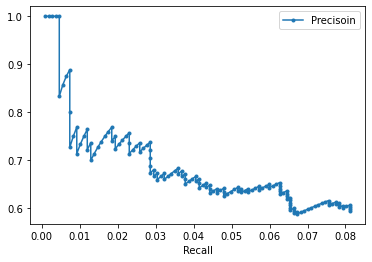

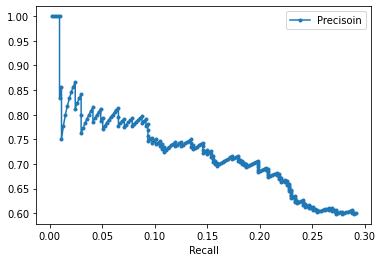

In [ ]:
#Ploting the PR curve 
confidenceTableOfMA.plot(x='Recall', y='Precisoin', marker='.')
confidenceTableOfHE.plot(x='Recall', y='Precisoin', marker='.')




> **Caculating the Area under the PR curve**



In [ ]:
x = []
x = confidenceTableOfMA['Recall']
y_scores = []
y = confidenceTableOfMA['Precisoin']
x = np.array(x)
y = np.array(y)
auc(x=x,y=y)

0.05510177448668356

In [ ]:
x = []
x = confidenceTableOfHE['Recall']
y_scores = []
y = confidenceTableOfHE['Precisoin']
x = np.array(x)
y = np.array(y)
auc(x=x,y=y)

0.20947334506760698